In [1]:
from inflation_analysis import grouping, calculate_price_indexes
from tabulate import tabulate
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


# Parameters
start_year = 2019
end_year = 2022
data_folder="/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/"
top_n = 10
base_year = start_year
years=range(start_year, end_year+1)

groups, total_mmb = grouping(start_year, end_year, cex_data_folder = data_folder)
groups_mmb = {key: {} for key in groups.keys()}
for key in groups:
    for year in years:
        groups_mmb[key][year] = groups[key][year][['misparmb']]

group_analysis = {}
for key in tqdm(groups.keys(), desc="Processing groups"):
    combined_df, combined_secondary_df, combined_primary_df, yearly_price_index = calculate_price_indexes(
        start_year, end_year, base_year, group_mmb=groups_mmb[key], cex_data_folder=data_folder, verbose=False
    )
    group_analysis[key] = {
        'combined_secondary_df': combined_secondary_df,
        'combined_primary_df': combined_primary_df,
        'yearly_price_index': yearly_price_index
    }


Processing groups: 100%|██████████| 11/11 [01:04<00:00,  5.91s/it]


In [2]:
gen_pop_df, gen_pop_secondary_df, gen_pop_primary_df, gen_pop_yearly_price_index = calculate_price_indexes(start_year, end_year, base_year, cex_data_folder=data_folder, verbose=False)

In [ ]:
group_counts = {group: {year: len(groups_mmb[group][year]) for year in groups_mmb[group]} for group in groups_mmb}
# Create a dataframe with number of observations per year per group
observations_df = pd.DataFrame(group_counts).T

# Calculate the relative share of each group per year
total_observations_per_year = observations_df.sum(axis=0)
relative_share_df = observations_df.div(total_observations_per_year, axis=1) * 100

# Combine the absolute and relative values into a single dataframe
combined_df = observations_df.join(relative_share_df, rsuffix='_share')

# Display the dataframe
print(tabulate(combined_df, headers='keys', tablefmt='psql'))

           2019  2020  2021  2022  2019_share  2020_share  2021_share  \
Arabs      1103   513   951   727   10.927284    7.490145   11.147579   
Haredi      565   440   551   595    5.597385    6.424296    6.458797   
Low_inc     646   397   503   515    6.399841    5.796467    5.896143   
High_inc   1848  1432  1479  1162   18.307906   20.908162   17.336772   
Young      1108   718   877   820   10.976818   10.483282   10.280155   
Old        2279  1786  1779  1663   22.577769   26.076800   20.853358   
Low_SES    1146   807  1204  1211   11.353279   11.782742   14.113234   
High_SES    189   163   153   146    1.872399    2.379909    1.793459   
Muslim      870   381   710   583    8.618982    5.562856    8.322588   
Christian   231   151   205   137    2.288488    2.204701    2.403001   
Druze       109    61   119    78    1.079849    0.890641    1.394913   

           2022_share  
Arabs        9.519445  
Haredi       7.791017  
Low_inc      6.743486  
High_inc    15.215399  
You

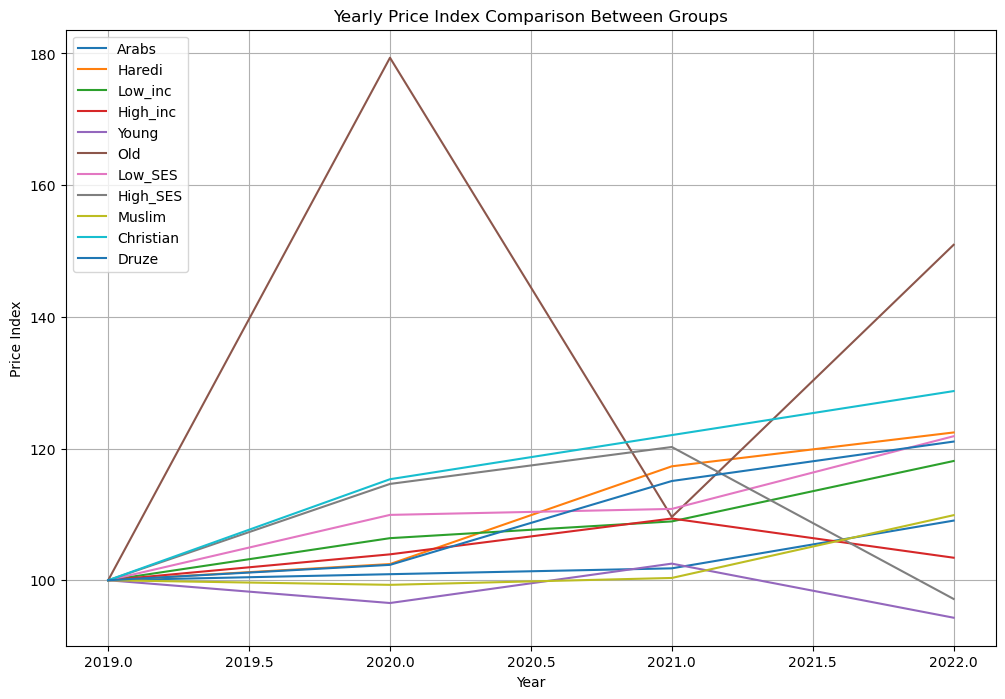

In [4]:
# Extract yearly price indexes for each group
group_yearly_price_indexes = {group: group_analysis[group]['yearly_price_index'] for group in group_analysis}

# Plot the yearly price indexes
plt.figure(figsize=(12, 8))
for group, price_indexes in group_yearly_price_indexes.items():
    years = list(price_indexes.keys())
    indexes = list(price_indexes.values())
    plt.plot(years, indexes, label=group)

plt.xlabel('Year')
plt.ylabel('Price Index')
plt.title('Yearly Price Index Comparison Between Groups')
plt.legend()
plt.grid(True)
plt.show()

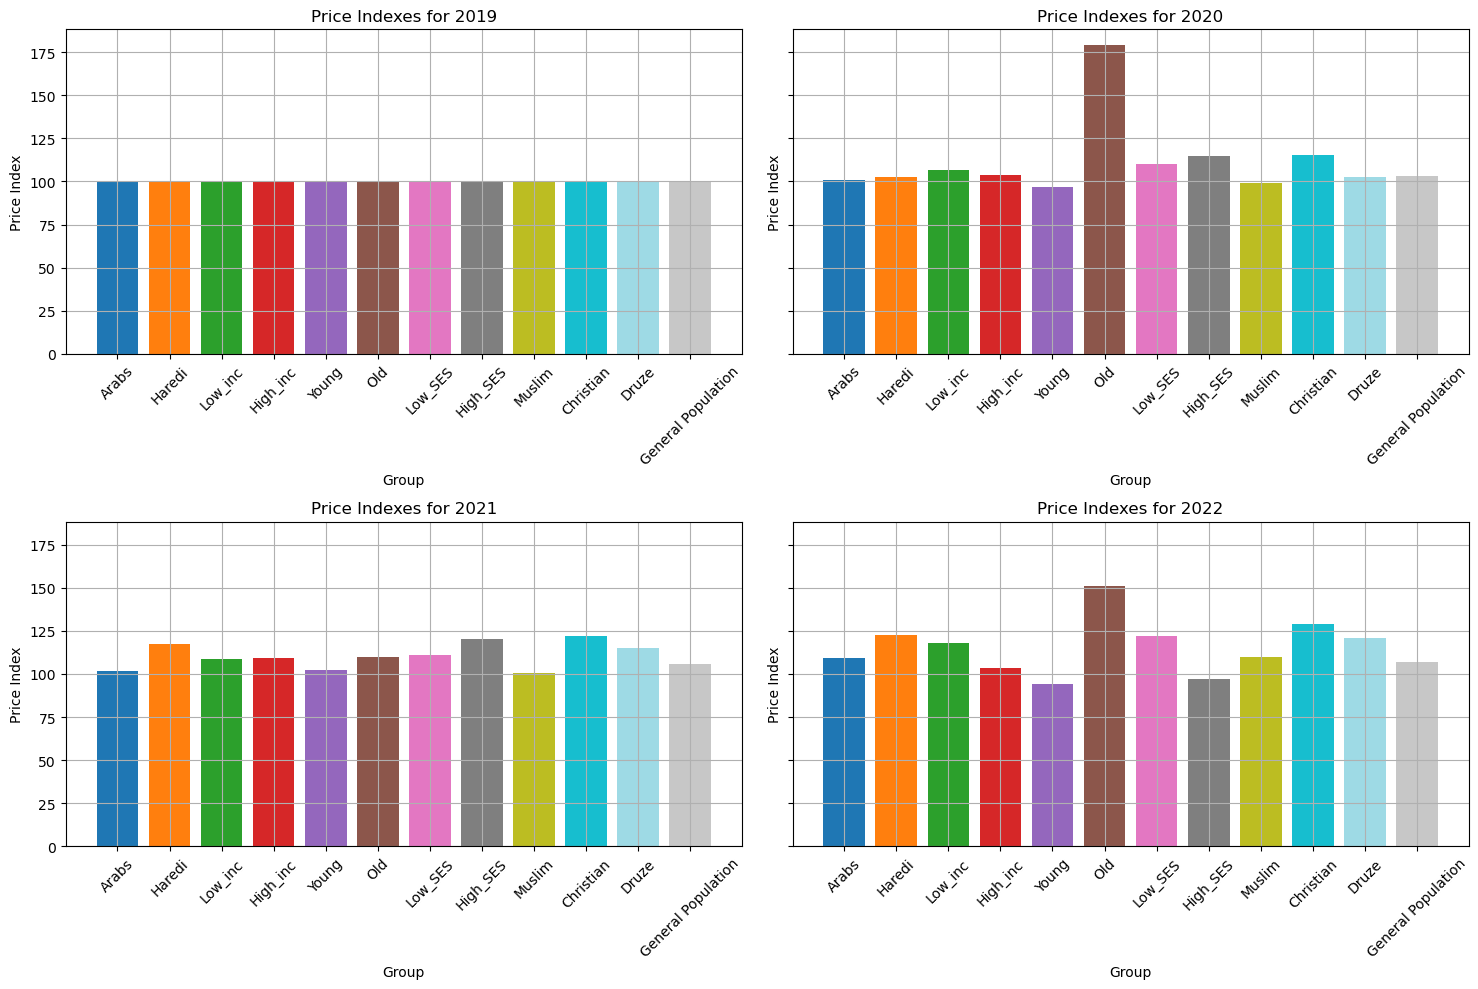

In [12]:
# Extract yearly price indexes for each group including general population
group_yearly_price_indexes = {group: group_analysis[group]['yearly_price_index'] for group in group_analysis}
group_yearly_price_indexes['General Population'] = gen_pop_yearly_price_index

# Define colors for each group
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#9edae5', '#c7c7c7']

# Create subplots for each year
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    groups = list(group_yearly_price_indexes.keys())
    price_indexes = [group_yearly_price_indexes[group][year] for group in groups]
    ax.bar(groups, price_indexes, color=colors)
    ax.set_title(f'Price Indexes for {year}')
    ax.set_xlabel('Group')
    ax.set_ylabel('Price Index')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

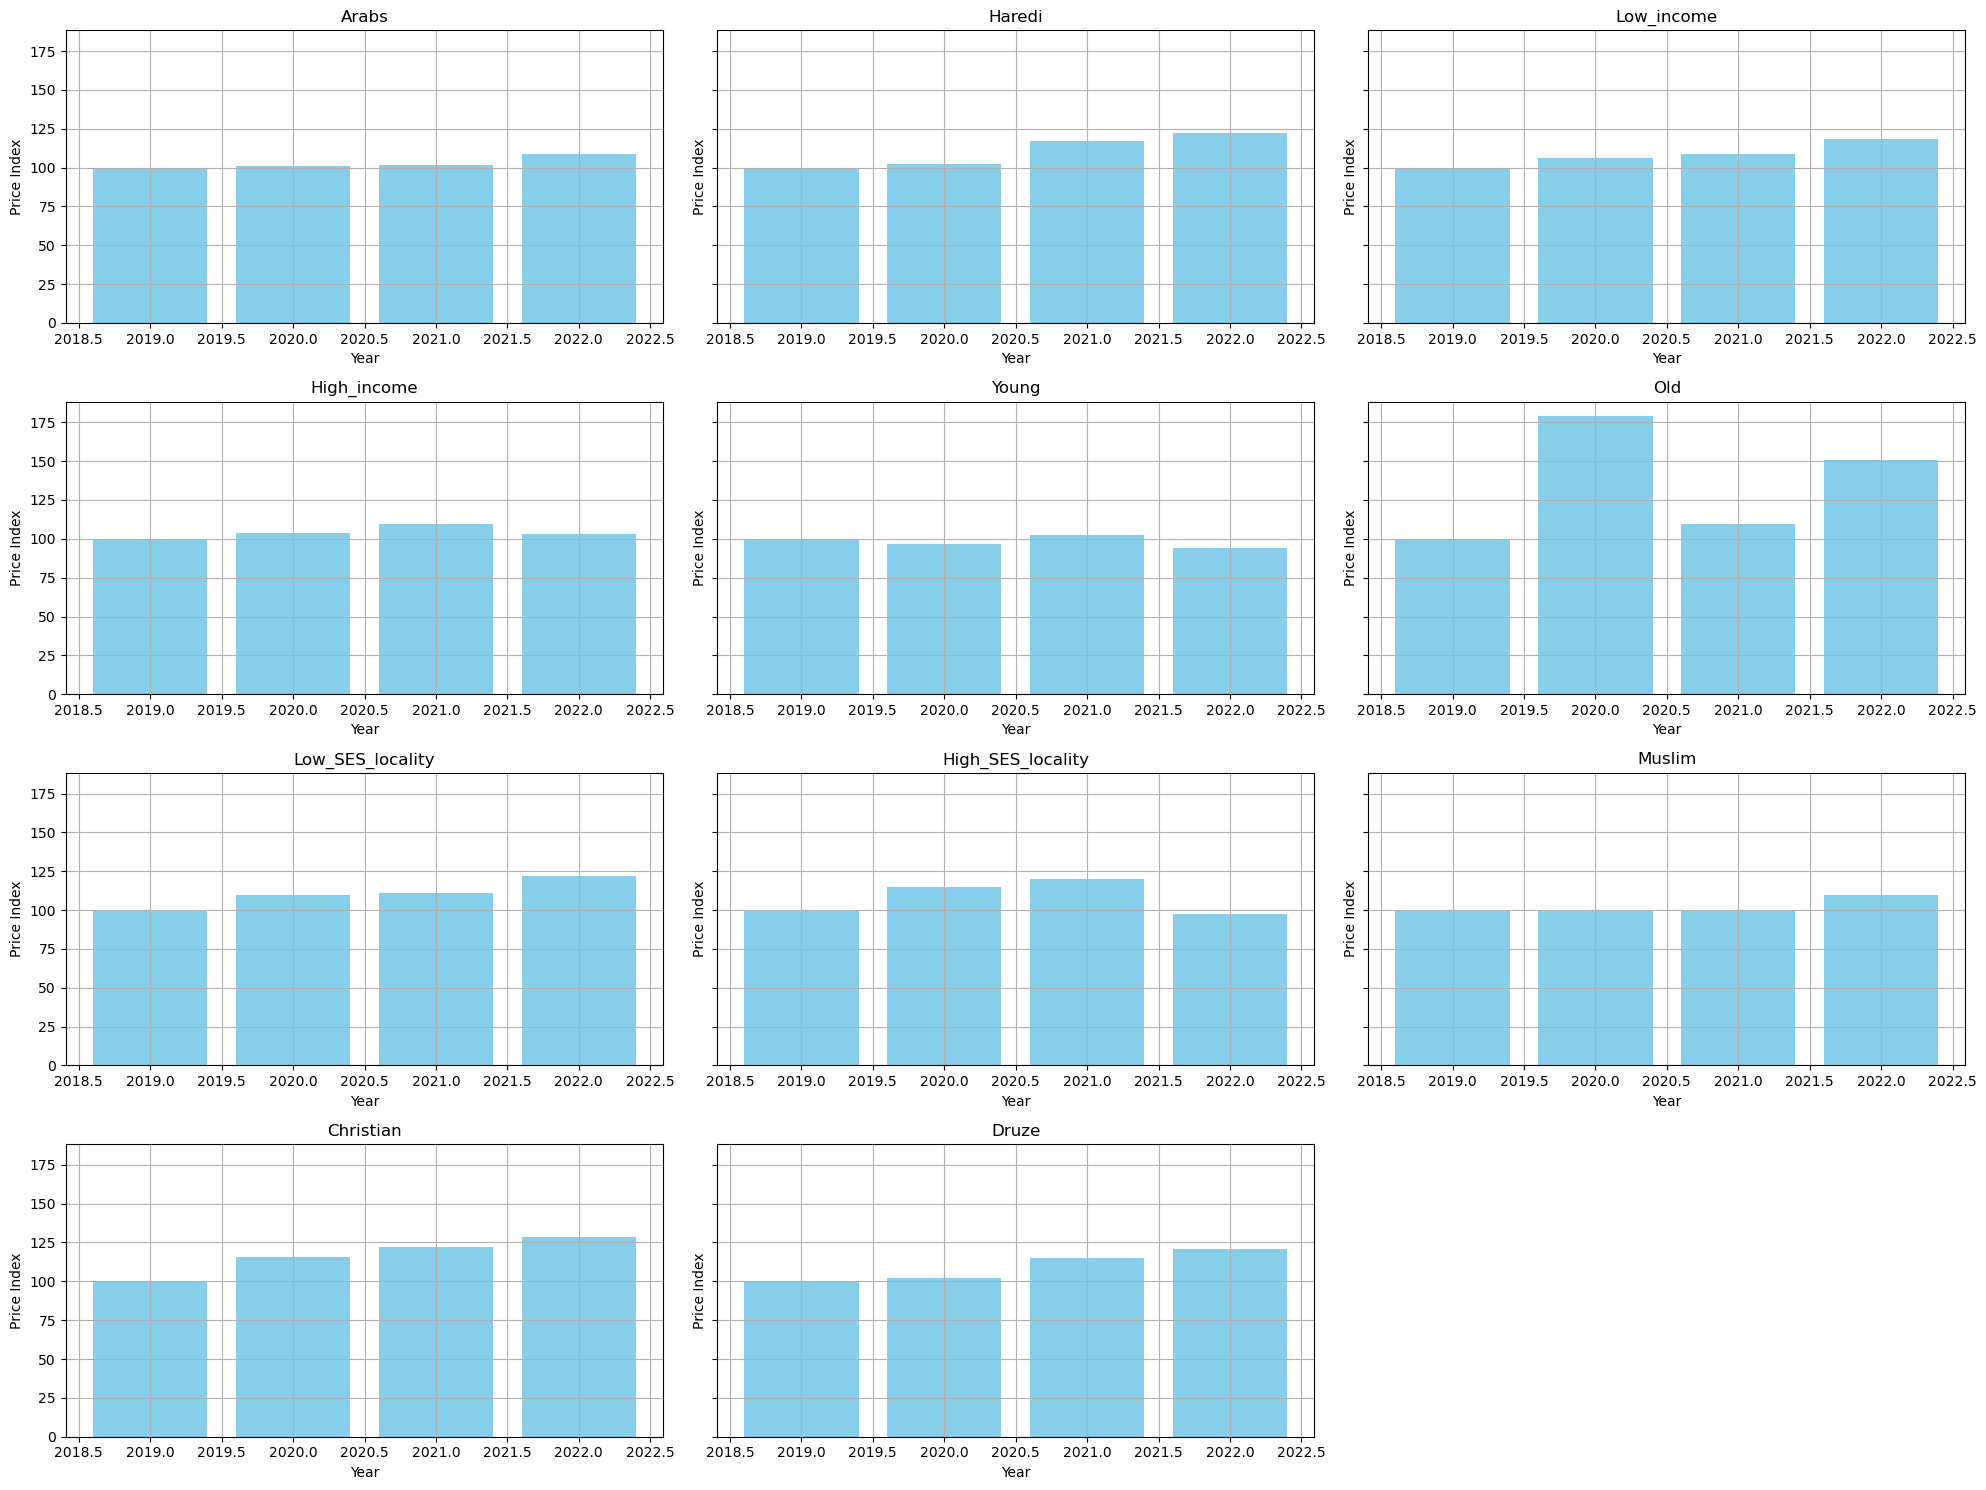

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15), sharey=True)
axes = axes.flatten()

for i, (group, data) in enumerate(group_analysis.items()):
    yearly_price_index = data['yearly_price_index']
    years = list(yearly_price_index.keys())
    indexes = list(yearly_price_index.values())
    
    axes[i].bar(years, indexes, color='skyblue')
    axes[i].set_title(group)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Price Index')
    axes[i].grid(True)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [12]:
for group, analysis in group_analysis.items():
    # Calculate the weight differences between the group and the general population for secondary categories
    weight_diff_df = analysis['combined_secondary_df'].copy()
    weight_diff_df['weight_diff'] = weight_diff_df['weight'] - gen_pop_secondary_df['weight']

    # Sort by the absolute value of the weight differences in descending order
    weight_diff_df['abs_weight_diff'] = weight_diff_df['weight_diff'].abs()
    sorted_weight_diff_df = weight_diff_df.sort_values(by='abs_weight_diff', ascending=False)

    # Display the top_n largest gaps
    print(f"Group: {group}")
    print(sorted_weight_diff_df[['Year', 'prodcode', 'description', 'weight', 'weight_diff']])
    print("\n")

Group: Arabs
     Year prodcode                              description    weight  \
249  2022      395             Personal Jewelry And Watches  0.002785   
116  2020      383                         Vehicle Expenses  0.124914   
55   2019      385         Mail Telephone And Communication  0.014118   
179  2021      383                         Vehicle Expenses  0.122662   
53   2019      383                         Vehicle Expenses  0.125787   
..    ...      ...                                      ...       ...   
46   2019      373  Culture Sports And Entertainment Events  0.003085   
44   2019      371                       Education Services  0.033368   
81   2020      318                     Natural Fruit Juices  0.000592   
104  2020      362                              Dental Care  0.011570   
58   2019      393          Personal Products And Cosmetics  0.013836   

     weight_diff  
249    -0.131559  
116     0.121741  
55     -0.121148  
179     0.116189  
53      0.11603

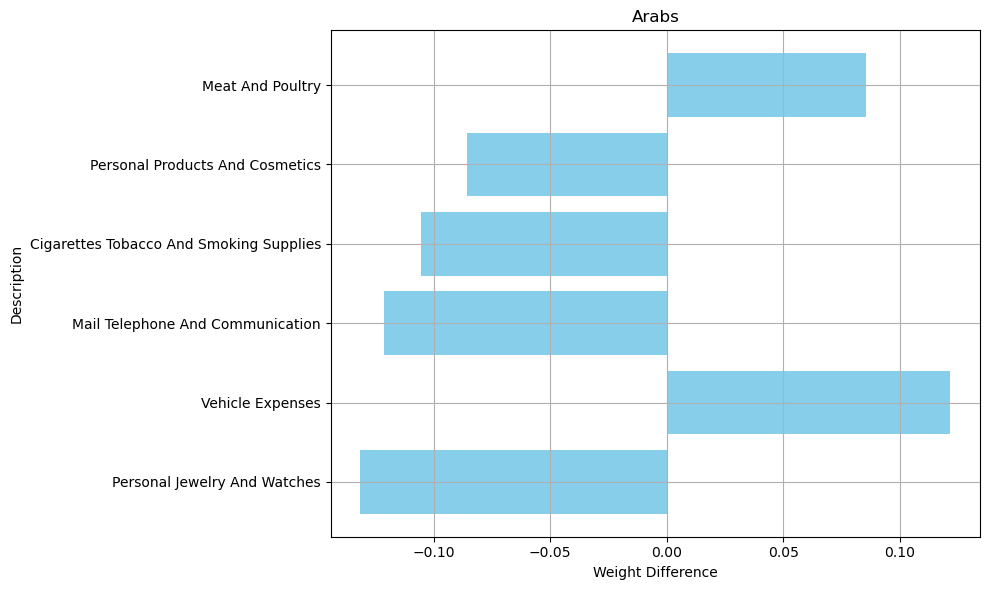

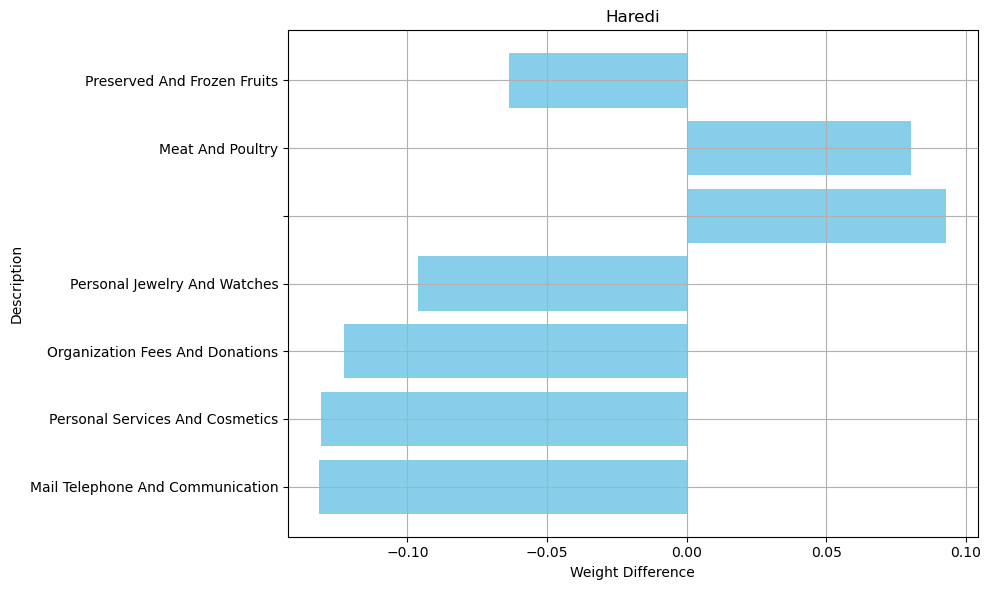

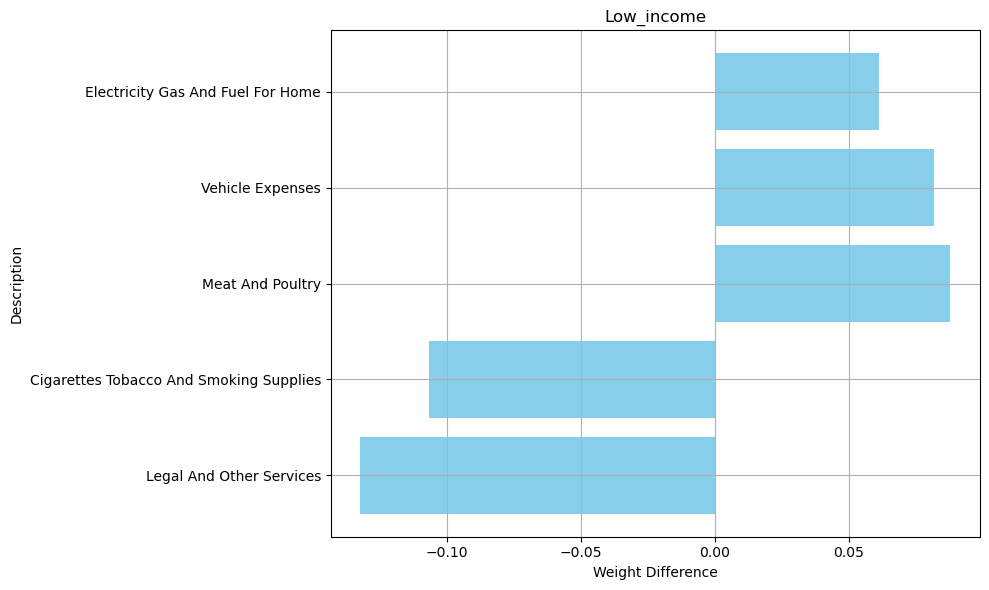

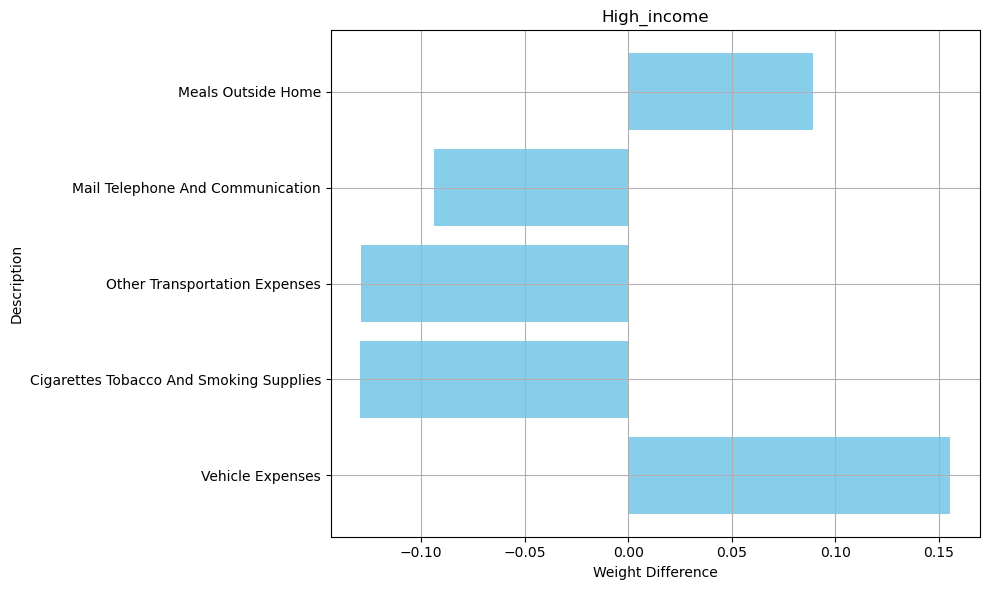

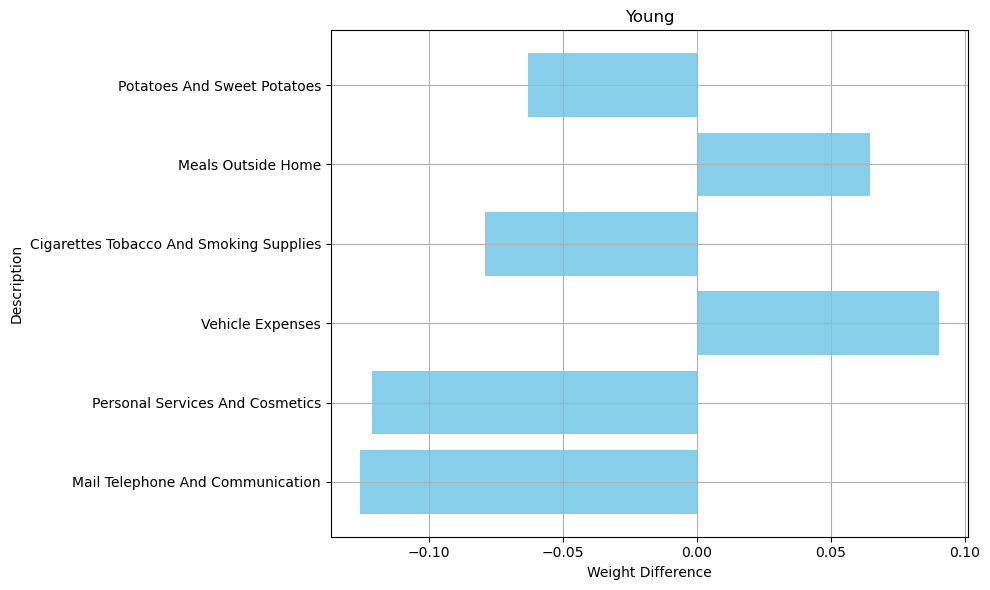

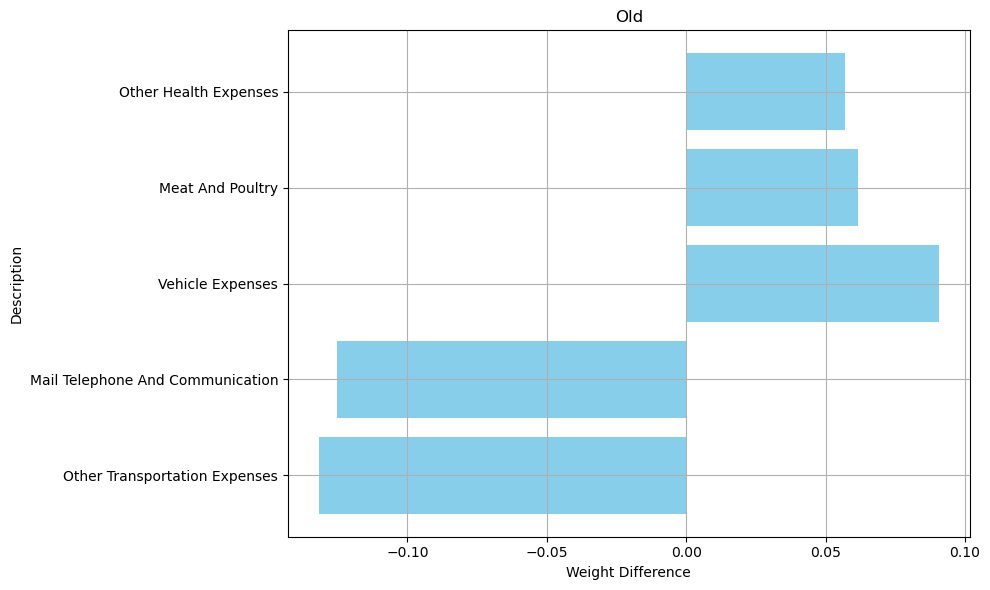

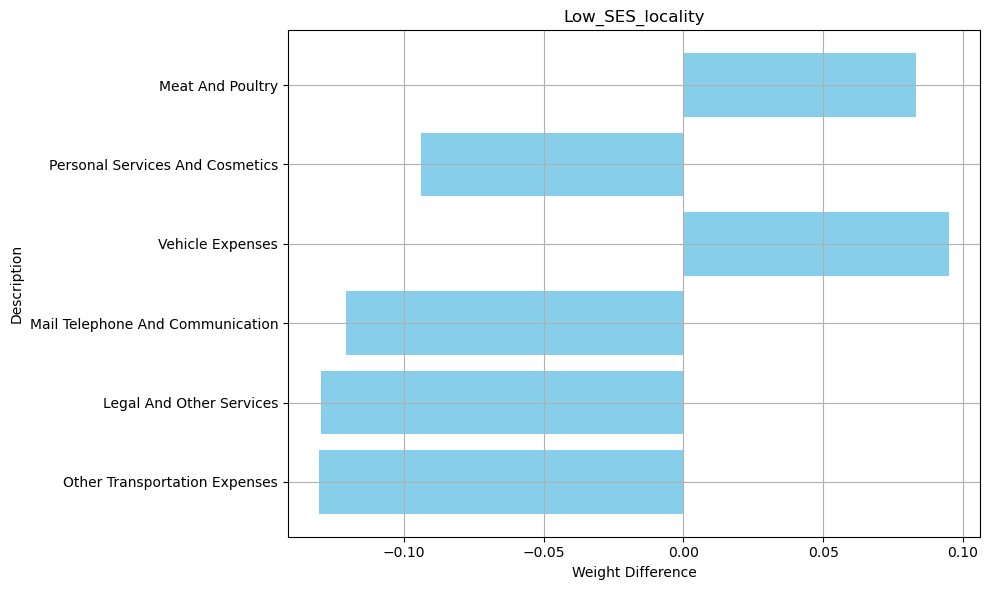

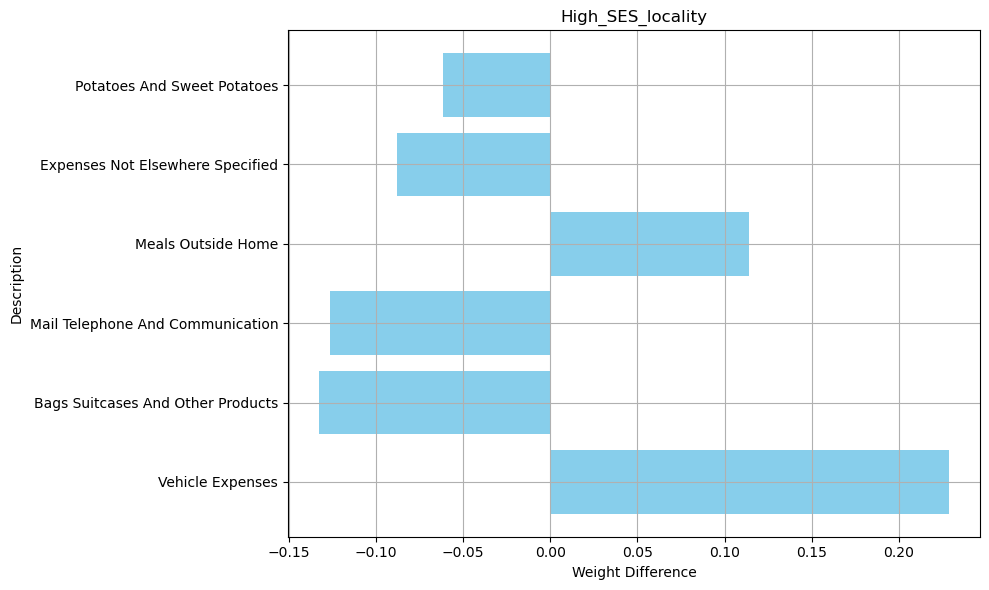

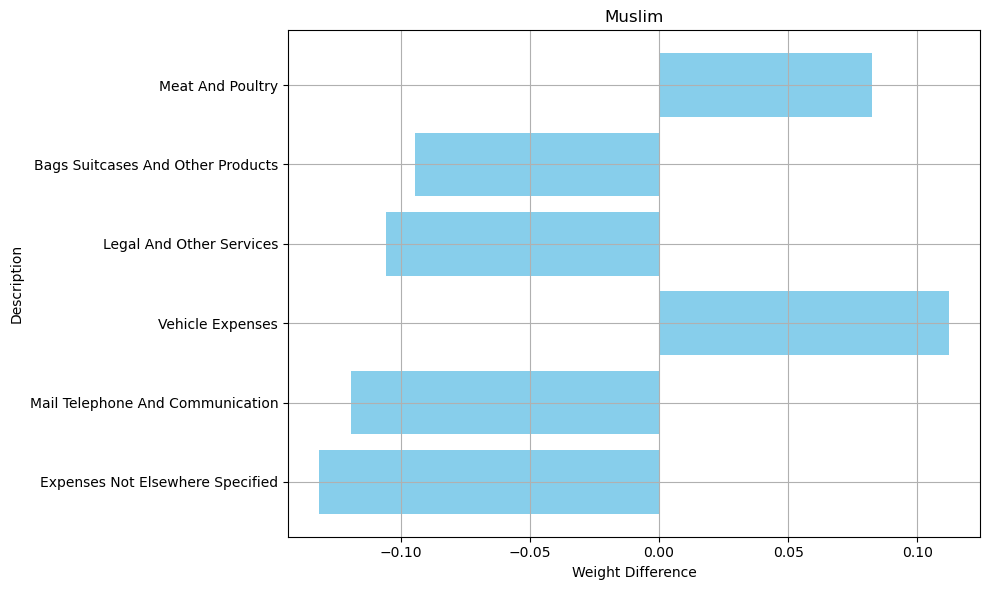

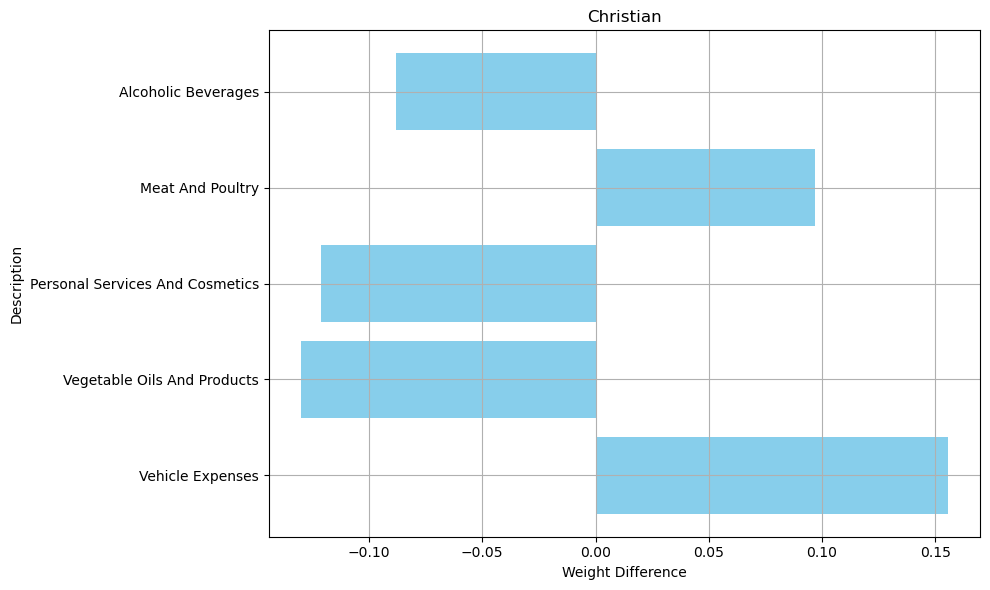

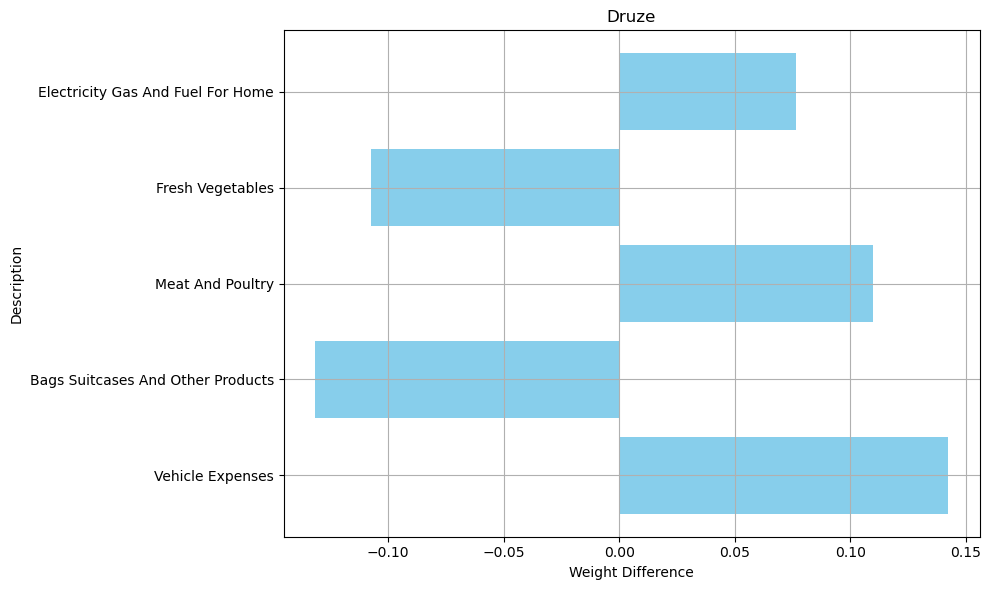

In [17]:
for group, analysis in group_analysis.items():
    # Calculate the weight differences between the group and the general population for secondary categories
    weight_diff_df = analysis['combined_secondary_df'].copy()
    weight_diff_df['weight_diff'] = weight_diff_df['weight'] - gen_pop_secondary_df['weight']

    # Sort by the absolute value of the weight differences in descending order
    weight_diff_df['abs_weight_diff'] = weight_diff_df['weight_diff'].abs()
    sorted_weight_diff_df = weight_diff_df.sort_values(by='abs_weight_diff', ascending=False)

    # Replace NaN values in 'description' with an empty string
    sorted_weight_diff_df['description'] = sorted_weight_diff_df['description'].fillna('')

    # Select the top n largest gaps
    top_n_weight_diff_df = sorted_weight_diff_df.head(top_n)

    # Plot the top n largest gaps
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_weight_diff_df['description'], top_n_weight_diff_df['weight_diff'], color='skyblue')
    plt.title(group)
    plt.xlabel('Weight Difference')
    plt.ylabel('Description')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
